Just importing the necessary libraries to work with the data.

In [1]:
import pandas as pd # Pandas to load the dataset and analyze it
import numpy as np # Numpy for arrays
import matplotlib.pyplot as plt # Matplotlib for visualization
import matplotlib.image as mpimg
import matplotlib as mplt

Reading the dataset.

In [41]:
ships = pd.read_csv('D:/airbus/train_ship_segmentations_v2.csv') 
ships.head(10) # 9 records from the top of the table

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
8,0001b1832.jpg,NaN
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


In [3]:
ships.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB


What can be seen:
- The 1st row of the table contains ids of images from the training set, the 2nd row contains an rle encoding of the mask
- Most of the images don't have any ships, only 82k of them have 1 or more ships

While it would be useful to keep some of the empty images around, I am going to drop all the images that do not have a ship, mainly so that image processing and training don't take a ridiculous amount of time.

In [42]:
ships_nonempty = ships.dropna().reset_index(drop=True)
ships_nonempty.head(10)

,ImageId,EncodedPixels
0,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
1,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
2,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
3,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
4,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
5,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
6,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...
7,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
8,00021ddc3.jpg,74441 3 75207 5 75975 5 76743 5 77511 5 78280 ...
9,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


In [5]:
ships_nonempty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81723 entries, 0 to 81722
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        81723 non-null  object
 1   EncodedPixels  81723 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


Next, I will need an rle decoder to get the masks (code taken from the internet).

In [6]:
def rle_decode(mask_rle, shape):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    return img.reshape(shape).T

Here are some of the original images:

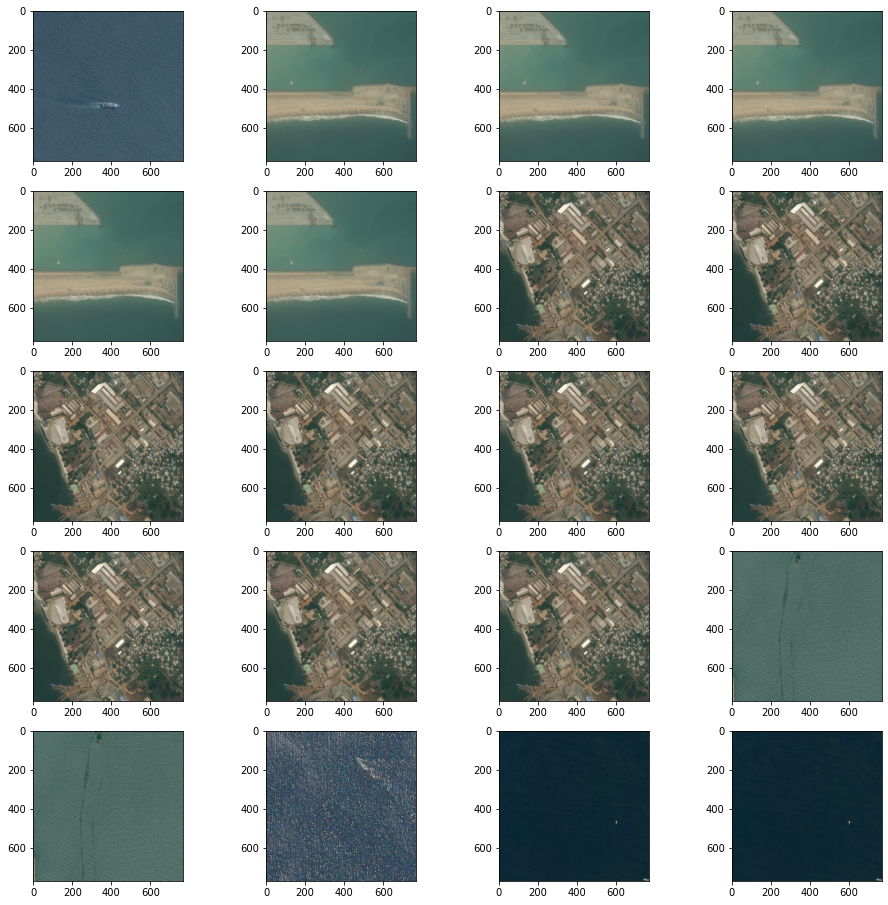

In [23]:
fig = plt.figure(figsize=(16, 16))
COLS = 4
ROWS = 5
for i in range(1, COLS*ROWS + 1):
    img = mpimg.imread(f'D:/airbus/train_v2/{ships_nonempty.ImageId[i-1]}')
    fig.add_subplot(ROWS,COLS, i)
    plt.imshow(img)
plt.show()

Here are their masks:

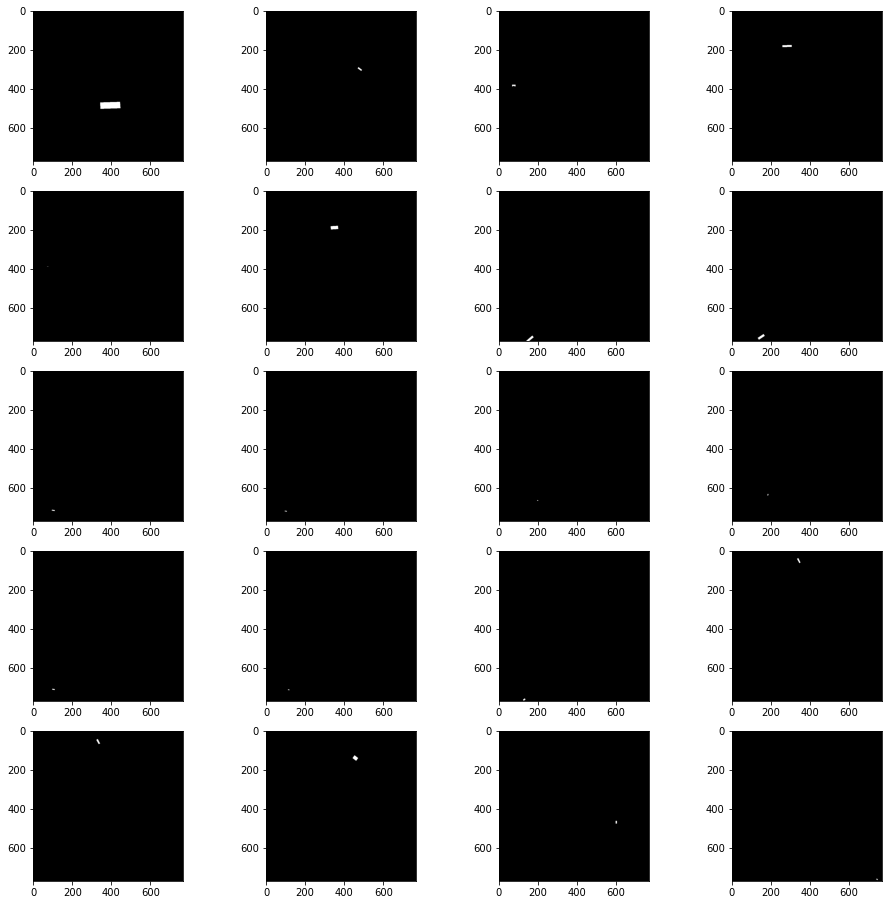

In [52]:
fig = plt.figure(figsize=(16, 16))
for i in range(1, COLS*ROWS + 1):
    mask = ships_nonempty["EncodedPixels"][i-1]
    mask = rle_decode(mask, (768, 768))
    fig.add_subplot(ROWS,COLS, i)
    plt.imshow(mask, cmap='gray')
plt.show()

Let's take a closer look at the 1st image and its mask

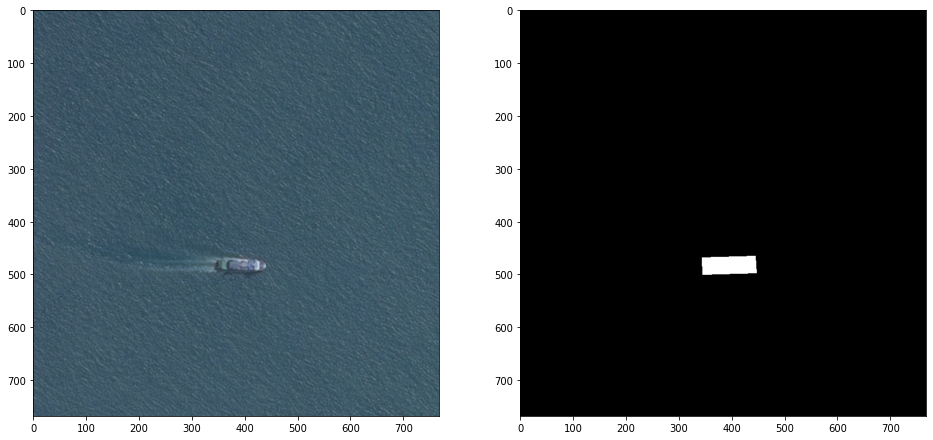

In [54]:
fig = plt.figure(figsize=(16, 16))
fig.add_subplot(1,2,1)
plt.imshow(mpimg.imread(f'D:/airbus/train_v2/{ships_nonempty.ImageId[0]}'))
fig.add_subplot(1,2,2)
plt.imshow(rle_decode(ships_nonempty["EncodedPixels"][0], (768,768)), cmap='gray')
plt.show()

What we can see, is that the masks were done somewhat crudely -- just a rectangle drawn over the ship that doesn't necessarily follow the exact shape of the ship. On top of that, a lot of the ships are very tiny compared to the rest of the image (image 5 barely even has any pixels), which will compound the problem of crude masks.

It seems that there are no masks with multiple ships, but the images themselves do contain multiple ships, seeing as the same images (can see repeating image ids in the dataset) have been used multiple times but with different masks. This creates a problem, because now different masks for the same image will have conflicting data -- on 1 mask the ship will be marked as a ship, prompting the model to (correctly) identify it, but on other images the same exact set of pixels will be identified as background and push back against the training that the model has done with the previous image.

The solution is to combine masks that belong to the same image into 1 mask with multiple ships and only keep the unique image ids in the input data. 

Example for images 2-6:

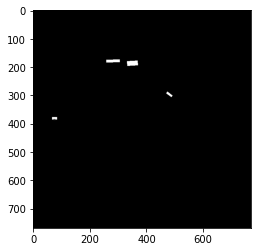

In [56]:
mask = np.zeros((768,768))
for i in np.arange(1,6):
    if (ships_nonempty['ImageId'][i] == ships_nonempty['ImageId'][i-1]):
        mask1 = rle_decode(ships_nonempty["EncodedPixels"][i-1], (768,768))
        mask2 = rle_decode(ships_nonempty["EncodedPixels"][i], (768,768))
        newmask = (mask1 == 1) | (mask2 == 1)
        mask = (newmask == 1) | (mask == 1)
plt.imshow(mask, cmap='gray')
plt.show()

In [58]:
from PIL import Image # PILLOW to process the images

I am going to resize all the images to 128x128. Working with 768x768 images will take a a very long time, both for image processing and especially for model training. The main goal of the project is simply to try and develop a u-net model and test it a little, so this should be fine.

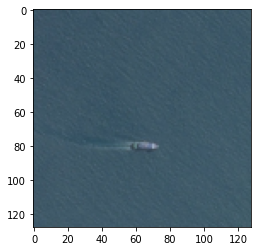

In [66]:
img = Image.open(f'D:/airbus/train_v2/{ships_nonempty.ImageId[0]}')
newimg = img.resize((128,128))
plt.imshow(newimg)
plt.show()

### Now it's time to construct the input data

Building the Y training set by combining the masks where it is needed, as well as resizing everything to 128x128

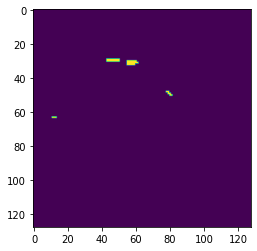

In [74]:
Y_trainl = [rle_decode(ships_nonempty["EncodedPixels"][0], (768,768))]
j = 0
for i in np.arange(1, ships_nonempty.ImageId.size):
    if (ships_nonempty.ImageId[i] == ships_nonempty.ImageId[i-1]):
        mask1 = Y_trainl[j]
        mask2 = rle_decode(ships_nonempty["EncodedPixels"][i], (768,768))
        Y_trainl[j] = (mask1 == 1) | (mask2 == 1)
    else: 
        j += 1
        mask2 = rle_decode(ships_nonempty["EncodedPixels"][i], (768,768))
        Y_trainl.append(mask2)
        
    
Y_train = np.zeros((len(Y_trainl),128,128),dtype=np.uint8)
for i in np.arange(0, len(Y_trainl)):
    img = Image.fromarray(Y_trainl[i])
    newimg = img.resize((128,128))
    Y_train[i] = newimg
    
plt.imshow(Y_train[1])
plt.show()

Mask array size:

In [75]:
print(len(Y_train))

42556


Dropping duplicate image ids:

In [83]:
ships_nonempty = ships_nonempty.drop_duplicates(subset='ImageId', keep='first').reset_index(drop=True)
ships_nonempty.head(10)

,ImageId,EncodedPixels
0,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
1,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
2,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...
3,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...
4,00031f145.jpg,340363 1 341129 4 341896 6 342663 7 343429 10 ...
5,000532683.jpg,458957 14 459725 14 460493 14 461261 14 462029...
6,00053c6ba.jpg,565382 3 566144 9 566909 12 567677 13 568445 1...
7,0005d01c8.jpg,56010 1 56777 3 57544 6 58312 7 59079 9 59846 ...
8,0005d6d95.jpg,265143 1 265910 4 266678 5 267445 7 268212 10 ...
9,0006c52e8.jpg,146366 1 147132 4 147899 5 148666 7 149432 10 ...


In [81]:
ships_nonempty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42556 entries, 0 to 42555
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        42556 non-null  object
 1   EncodedPixels  42556 non-null  object
dtypes: object(2)
memory usage: 665.1+ KB


The sizes match -- 42556 elements in each set.

Next, I am going to convert all training images into 128x128x3 arrays to serve as inputs for the model.

In [85]:
X_train = np.zeros((len(ships_nonempty.ImageId),128,128,3), dtype=np.uint8)
i = 0
for trainid in ships_nonempty.ImageId:
    img = Image.open(f'D:/airbus/train_v2/{trainid}')
    newimg = img.resize((128,128))
    X_train[i] = newimg
    i += 1

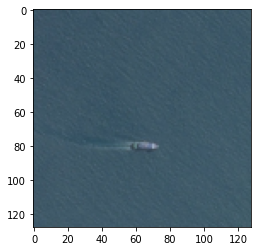

In [86]:
plt.imshow(X_train[0])
plt.show()

It's clear to see that the quality is noticeably worse (especially with the masks, some of them are offset really awkwardly now), but it is what it is.<br>
Going to have to also split the arrays for testing, but that will be in the model training file.

Now, the training data is ready to be plugged into the model. Obviously, the architecture is going to be u-net (typically preferred for image segmentation tasks). For the metric I am going to use Accuracy. I know, it is advised to use dice score for this task, but tf.keras doesn't have a built-in implementation of it, and when I tried to define it myself, there was a conflict with data types (I would have to convert image arrays into float, and that would take way too much memory). There are roughly 42k images, so I am going to do batches of 100, and after seeing how long each epoch was taking, I decided to settle on 4 epochs. 